In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [2]:
x = np.load("data/xtrain32.npy")

y = np.load("data/ytrain.npy")
print(x[0])
print(x.shape)
print(y.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(300000, 28, 56)
(300000,)


In [3]:
from matplotlib import pyplot as plt

41


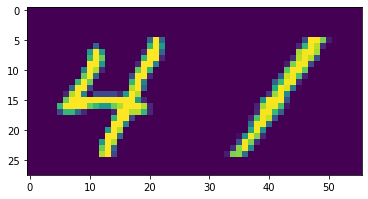

In [4]:
plt.imshow(x[250004])
print(y[250004])

In [5]:
x = torch.Tensor(x[:60000, :, 28:]).to(torch.int8)
y = torch.Tensor(y[:60000]).to(torch.int8)

#x = np.array(x[:60000, :, 28:], dtype=np.uint8)
#y = torch.Tensor(np.array(y[:60000], dtype=np.uint8))

tensor(5, dtype=torch.int8)


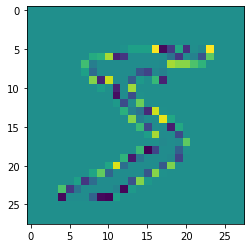

In [6]:
plt.imshow(x[0])
print(y[0])
#print(torch.max(x))

In [7]:
from PIL import Image

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        x = Image.fromarray(x.numpy(), mode='L')
        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [8]:
os.makedirs("images/small10", exist_ok=True)


digit_embeddings = np.load("digit_embeddings.npy")

class Arguments():
  def __init__(self):
    self.n_epochs = 200
    self.batch_size = 64
    self.lr = 0.0002
    self.b1 = 0.5
    self.b2 = 0.999
    self.n_cpu = 8
    self.latent_dim = 100
    self.n_classes = 10
    self.img_size = 32
    self.channels = 1
    self.sample_interval = 1000
    self.embedding_size = 50
    self.n_discriminator = 1

opt = Arguments()

img_shape = (opt.channels, opt.img_size, opt.img_size)#*2)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Linear(opt.embedding_size, opt.embedding_size)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.embedding_size, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Linear(opt.embedding_size, opt.embedding_size)

        self.model = nn.Sequential(
            nn.Linear(opt.embedding_size + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
dataloader = torch.utils.data.DataLoader(
    CustomTensorDataset(tensors = (x, y), transform = transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
       )),
    batch_size=opt.batch_size,
    shuffle=True,
)

total_d_loss = 0.0
total_g_loss = 0.0

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

#numbers = np.random.randint(0, 49, [10])
#numbers = np.sort(numbers)
numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
print("Numbers", numbers)
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    """does not use n_row"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (10*10, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(10) for num in numbers])
    gen_labels = Variable(FloatTensor(digit_embeddings[labels]))
    gen_imgs = generator(z, gen_labels)
    save_image(gen_imgs.data, "images/small10/%d.png" % batches_done, nrow=10, normalize=True)


# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        #print('Max', torch.max(real_imgs))
        #print('Min', torch.min(real_imgs))
        labels = Variable(FloatTensor(digit_embeddings[labels]))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(FloatTensor(digit_embeddings[np.random.randint(0, opt.n_classes, batch_size)]))
        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)
        
        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)
        total_g_loss += g_loss.item()
        
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        if i%opt.n_discriminator==0:
            optimizer_D.zero_grad()

            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)

            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2
            total_d_loss += d_loss.item()

            d_loss.backward()
            optimizer_D.step()
            
        if i%1000==0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), total_d_loss/(1000/opt.n_discriminator), total_g_loss/1000)
            )
            total_d_loss = 0.0
            total_g_loss = 0.0

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=20, batches_done=batches_done)

Numbers [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[Epoch 0/200] [Batch 0/938] [D loss: 0.000506] [G loss: 0.001054]
[Epoch 1/200] [Batch 0/938] [D loss: 0.130962] [G loss: 0.543083]
[Epoch 2/200] [Batch 0/938] [D loss: 0.111893] [G loss: 0.588376]
[Epoch 3/200] [Batch 0/938] [D loss: 0.107274] [G loss: 0.608625]
[Epoch 4/200] [Batch 0/938] [D loss: 0.113977] [G loss: 0.594503]
[Epoch 5/200] [Batch 0/938] [D loss: 0.123180] [G loss: 0.563834]
[Epoch 6/200] [Batch 0/938] [D loss: 0.129512] [G loss: 0.546374]
[Epoch 7/200] [Batch 0/938] [D loss: 0.139164] [G loss: 0.515198]
[Epoch 8/200] [Batch 0/938] [D loss: 0.148931] [G loss: 0.487675]
[Epoch 9/200] [Batch 0/938] [D loss: 0.154173] [G loss: 0.471094]
[Epoch 10/200] [Batch 0/938] [D loss: 0.156345] [G loss: 0.465795]
[Epoch 11/200] [Batch 0/938] [D loss: 0.159263] [G loss: 0.457037]
[Epoch 12/200] [Batch 0/938] [D loss: 0.160868] [G loss: 0.451761]
[Epoch 13/200] [Batch 0/938] [D loss: 0.163038] [G loss: 0.449194]
[Epoch 14/200] [Batch 0/938] [D l

KeyboardInterrupt: 